In [39]:
# import
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import re
import json
import requests
import mplleaflet

import config

from bs4 import BeautifulSoup

In [5]:
csv_name = '176JourneyDataExtract21Aug2019-27Aug2019.csv'
names = pd.read_csv(csv_name, nrows=1).columns
names = names.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

df = pd.read_csv(csv_name,
                 names=names,
                 index_col = 0,
                 skiprows = 1,
                 usecols=['rental_id', 'duration', 'bike_id', 'end_date', 'endstation_id',
                          'start_date', 'startstation_id'])
df.dropna(inplace = True)

# some fields have seconds added, some don't.
# it's faster to slice strings first [:16] and then convert using specified format
df.start_date = pd.to_datetime(df.start_date.str[:16], format="%d/%m/%Y %H:%M")
df.end_date = pd.to_datetime(df.end_date.str[:16], format="%d/%m/%Y %H:%M")

# convert duration to minutes
df.duration = df.duration/60

In [6]:
print(df.shape)
df.head()

(242194, 6)


,duration,bike_id,end_date,endstation_id,start_date,startstation_id
rental_id,,,,,,
90477391,5.0,379,2019-08-23 22:57:00,109,2019-08-23 22:52:00,77
90477176,7.0,379,2019-08-23 22:45:00,77,2019-08-23 22:38:00,109
90475826,18.0,13429,2019-08-23 21:36:00,192,2019-08-23 21:18:00,194
90496646,5.0,15653,2019-08-24 16:17:00,715,2019-08-24 16:12:00,464
90511107,4.0,3278,2019-08-25 01:46:00,715,2019-08-25 01:42:00,464


In [7]:
df.describe(include='all')

,duration,bike_id,end_date,endstation_id,start_date,startstation_id
count,242194.000000,242194.000000,242194,242194.000000,242194,242194.000000
unique,NaN,NaN,9711,NaN,9682,NaN
top,NaN,NaN,2019-08-27 18:01:00,NaN,2019-08-27 18:03:00,NaN
freq,NaN,NaN,109,NaN,114,NaN
first,NaN,NaN,2019-08-21 00:06:00,NaN,2019-08-21 00:00:00,NaN
last,NaN,NaN,2019-08-27 23:59:00,NaN,2019-08-27 23:57:00,NaN
mean,23.834864,9096.404787,NaN,387.529014,NaN,387.292621
std,66.777906,5071.170281,NaN,244.238187,NaN,243.972635
min,1.000000,2.000000,NaN,1.000000,NaN,1.000000
25%,9.000000,4690.000000,NaN,184.000000,NaN,183.000000


In [8]:
df.dtypes

duration                  float64
bike_id                     int64
end_date           datetime64[ns]
endstation_id               int64
start_date         datetime64[ns]
startstation_id             int64
dtype: object

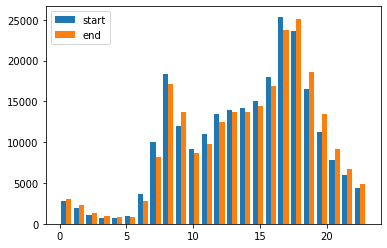

In [9]:
plt.hist([df.start_date.dt.hour, df.end_date.dt.hour], bins=24, label=['start','end'])
plt.legend(loc='upper left')
plt.show()

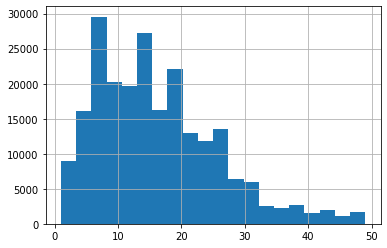

In [11]:
(df.duration[df.duration<50]).hist(bins= 20)
plt.show()

# Parse links

In [4]:
def get_links_list(online=False):
    links_list = []

    if online: 
        url = 'https://cycling.data.tfl.gov.uk/'
        html_page = urllib.request.urlopen(url)
    else:
        html_page = open("cycling.data.tfl.gov.uk.html")   

    soup = BeautifulSoup(html_page)

    for link in soup.findAll('a'):
        href = link.get('href')
        if 'usage-stats' in href and href.endswith('csv'):
            links_list.append(href)

    return links_list

get_links_list()

FileNotFoundError: [Errno 2] No such file or directory: 'cycling.data.tfl.gov.uk.html'

# Stations location

In [38]:
bikes_location_url = f"https://api.tfl.gov.uk/BikePoint?app_id={config.tfl_app_id}&app_key={config.tfl_app_key}"
bikes_location_url = "https://api.tfl.gov.uk/BikePoint"
cred = {'app_id':config.tfl_app_id, 'app_key':config.tfl_app_key}
r = requests.get(url = URL, params = PARAMS)


req = urllib.request.Request(bikes_location_url, headers = cred)
response = urllib.request.urlopen(req)


# html_page = urllib.request.urlopen(bikes_location_url)
# soup = BeautifulSoup(html_page)

station_loc = []

for jsonobject in json.loads(str(soup)):
    features = {
        'id': jsonobject['id'][11:],
        'commonName': jsonobject['commonName'],
        'longitude': jsonobject['lon'],
        'latitude': jsonobject['lat']
    }

#     {'TerminalName': '001023',
#      'Installed': 'true',
#      'Locked': 'false',
#      'InstallDate': '1278947280000',
#      'RemovalDate': '',
#      'Temporary': 'false',
#      'NbBikes': '7',
#      'NbEmptyDocks': '12',
#      'NbDocks': '19'}
    features.update(dict([[d['key'], d['value']] for d in jsonobject['additionalProperties']]))
    station_loc.append(features)

station_loc = pd.DataFrame.from_dict(station_loc).set_index('id')
station_loc.columns = [re.sub('(?!^)([A-Z]+)', r'_\1', x).lower() for x in station_loc.columns]
station_loc['install_date'] = pd.to_datetime(station_loc['install_date'],unit='ms')
station_loc['removal_date'] = pd.to_datetime(station_loc['removal_date'],unit='ms')

URLError: <urlopen error [Errno -2] Name or service not known>

In [ ]:
station_loc.head()

In [34]:
data

'app_id=2c7ce594&app_key=1ac9f7f736449b3d2815095c3b1219a6'

In [ ]:
# plt.hold(True)
cartodb_dark_matter = (
    'https://a.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png',
    '&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> &copy; <a href="http://cartodb.com/attributions">CARTO</a>'
)

fig = plt.gcf()
fig.set_size_inches(7, 5)
plt.plot(station_loc.longitude, station_loc.latitude, 'r.') # Draw red dots
mplleaflet.display(tiles=cartodb_dark_matter) #'cartodb_positron'

# Predict road

In [ ]:
# TODO: Create API key

import openrouteservice

coords = ((8.34234,48.23424),(8.34423,48.26424))
client = openrouteservice.Client(key='') # Specify your personal API key
routes = client.directions(coords, profile='cycling-regular')
print(routes)

# Weather and air pollution

In [ ]:
# pip install pyowm
owm = pyowm.OWM('your-API-key')  # You MUST provide a valid API key

# Search for current weather in London (Great Britain)
observation = owm.weather_at_place('London,GB')
w = observation.get_weather()
print(w)                      # <Weather - reference time=2013-12-18 09:20,
                              # status=Clouds>

# Weather details
w.get_wind()                  # {'speed': 4.6, 'deg': 330}
w.get_humidity()              # 87
w.get_temperature('celsius')  # {'temp_max': 10.5, 'temp': 9.7, 'temp_min': 9.0}

w.to_JSON()

In [23]:
from tfl.client import Client
from tfl.api_token import ApiToken

app_id = config.tfl_app_id
app_key = config.tfl_app_key

token = ApiToken(app_id, app_key)

client = Client(token)
print (client.get_line_meta_modes())
print (client.get_lines(mode="bus")[0])
print (client.get_lines(line_id="victoria")[0])

[<tfl.models.mode.Mode object at 0x7f725cf5ceb8>, <tfl.models.mode.Mode object at 0x7f725cf5cef0>, <tfl.models.mode.Mode object at 0x7f725cf5ca20>, <tfl.models.mode.Mode object at 0x7f725cf5cf60>, <tfl.models.mode.Mode object at 0x7f725cf5c3c8>, <tfl.models.mode.Mode object at 0x7f725cf5c4e0>, <tfl.models.mode.Mode object at 0x7f7257c86b00>, <tfl.models.mode.Mode object at 0x7f7257c86a90>, <tfl.models.mode.Mode object at 0x7f7257c861d0>, <tfl.models.mode.Mode object at 0x7f7257c869e8>, <tfl.models.mode.Mode object at 0x7f7257c86b70>, <tfl.models.mode.Mode object at 0x7f7257c86978>, <tfl.models.mode.Mode object at 0x7f7257c86a58>, <tfl.models.mode.Mode object at 0x7f7257c86a20>, <tfl.models.mode.Mode object at 0x7f7257c86940>, <tfl.models.mode.Mode object at 0x7f7257c86b38>, <tfl.models.mode.Mode object at 0x7f7257c86ac8>, <tfl.models.mode.Mode object at 0x7f7257c86ba8>]
{'additional_properties': {'$type': 'Tfl.Api.Presentation.Entities.Line, Tfl.Api.Presentation.Entities'}, 'id': '1', 

In [24]:
f"https://api.tfl.gov.uk/BikePoint?app_id={config.tfl_app_id}&app_key={config.tfl_app_key}"

'https://api.tfl.gov.uk/BikePoint?app_id=2c7ce594&app_key=1ac9f7f736449b3d2815095c3b1219a6'